In [ ]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpmath import *
#plt.style.use('dark_background')
#
## Define your custom colors
#colors = [
#    '#08F7FE',  # teal/cyan
#    '#FE53BB',  # pink
#    '#F5D300',  # yellow
#    '#00ff41',  # matrix green
#    '#FF00FF',  # magenta
#    '#FFA500',  # orange
#    '#00FFFF',  # cyan
#]
#
## Set the custom color cycle
#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)


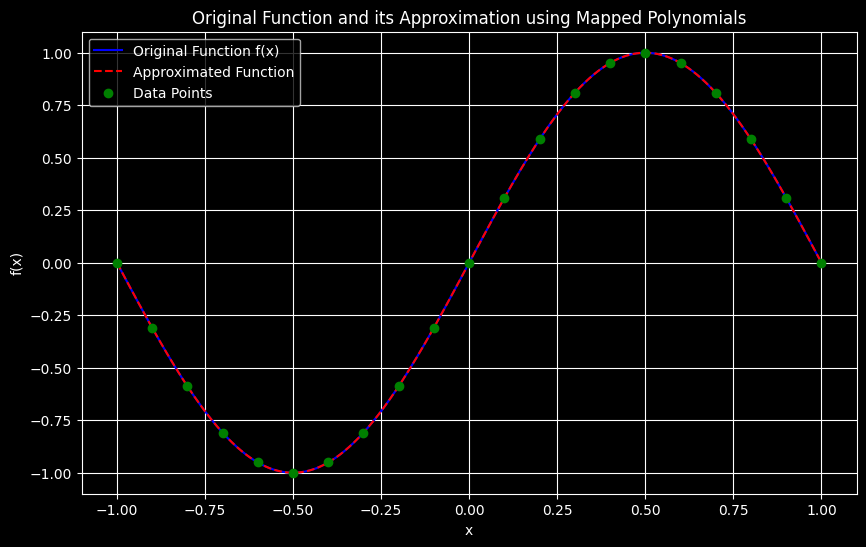

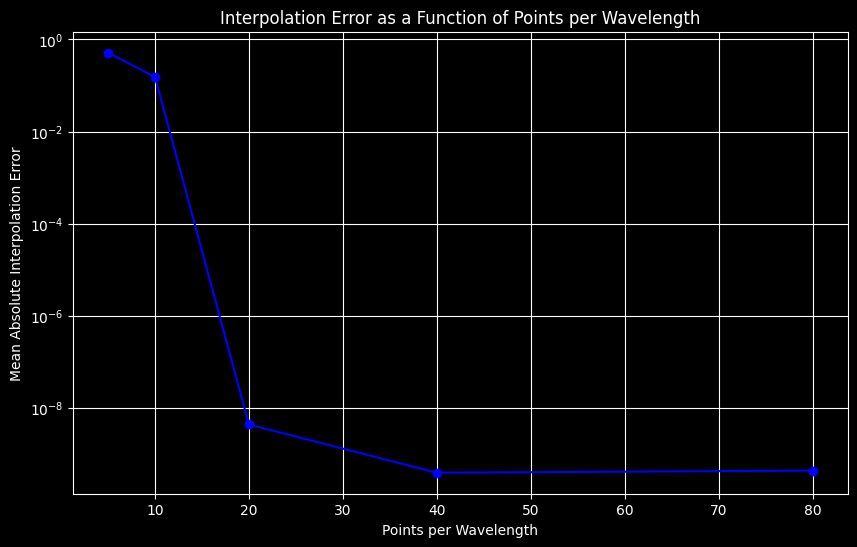

In [ ]:
import numpy as np
from scipy.linalg import svd
from numpy import sin, arcsin, sqrt, cos, pi

# Step 1: Define the mapping function
def mapping(x, alpha):
    return sin(alpha * pi * x / 2) / sin(alpha * pi / 2)

# Step 2: Define the function to compute weights μm
def compute_weights(zm, alpha):
    beta = sin(alpha * pi / 2)
    mu = np.zeros(len(zm))
    for n in range(len(zm)):
        if n == 0:
            mu[n] = (1/2) * (arcsin(mapping(zm[n+1], alpha)) - arcsin(mapping(zm[n], alpha)))
        elif n == len(zm) - 1:
            mu[n] = (1/2) * (arcsin(mapping(zm[n], alpha)) - arcsin(mapping(zm[n-1], alpha)))
        else:
            mu[n] = (1/2) * (arcsin(mapping(zm[n+1], alpha)) - arcsin(mapping(zm[n-1], alpha)))
    return mu

# Step 3: Define the basis functions φn(x)
def phi_n(x, n, alpha):
    cn = sqrt(1/pi) if n == 0 else sqrt(2/pi)
    return cn * cos(n * np.arccos(mapping(x, alpha)))

# Step 4: Define the main function to construct the matrices and solve the least squares problem
def mapped_polynomial_approximation(f, alpha, M, N):
    # Create the grid points zm
    zm = np.linspace(-1, 1, M+1)

    # Compute the weights μm
    mu = compute_weights(zm, alpha)
    sqrt_mu = np.sqrt(mu)

    # Create the matrix A
    A = np.zeros((M+1, N+1))
    for m in range(M+1):
        for n in range(N+1):
            A[m, n] = sqrt_mu[m] * phi_n(zm[m], n, alpha)

    # Compute the vector b
    b = sqrt_mu * f(zm)

    # Solve the least squares problem using SVD
    U, s, Vh = svd(A, full_matrices=False)
    c = np.dot(U.T, b) / s
    a = np.dot(Vh.T, c)

    return a, zm

# Step 5: Define the function to compute the approximation at any point x
def approximation(x, a, alpha):
    N = len(a) - 1
    return sum(a[n] * phi_n(x, n, alpha) for n in range(N+1))

# Step 6: Plot the original function and its approximation
def plot_approximation(f, a, alpha, zm):
    x_plot = np.linspace(-1, 1, 1000)
    f_plot = f(x_plot)
    approx_plot = np.array([approximation(x, a, alpha) for x in x_plot])

    plt.figure(figsize=(10, 6))
    plt.plot(x_plot, f_plot, label='Original Function f(x)', color='blue')
    plt.plot(x_plot, approx_plot, label='Approximated Function', linestyle='--', color='red')
    plt.scatter(zm, f(zm), color='green', zorder=5, label='Data Points')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('Original Function and its Approximation using Mapped Polynomials')
    plt.grid(True)
    plt.show()

# Measure the interpolation error
def measure_error(f, alpha, M, N, test_points):
    a, zm = mapped_polynomial_approximation(f, alpha, M, N)
    errors = []
    for x in test_points:
        approx_val = approximation(x, a, alpha)
        true_val = f(x)
        errors.append(np.abs(true_val - approx_val))
    return np.mean(errors)

In [2]:

def mapping(x, alpha):
    return np.sin(alpha * np.pi * x/2) / np.sin(alpha * np.pi / 2)



def f2ext(n_phys, n_ext, n_mode, precision=32, cutoff=1e-16):
    mp.dps = precision  # Set decimal precision

    # Adjust domain calculations to cover [-1, 1]
    x_ext = mp.linspace(-1, 1, n_phys + n_ext)  # Extended domain
    # Find physical domain within extended domain, centered
    start_index = (n_ext // 2)
    x_phys = x_ext[start_index:start_index + n_phys]

    # Initialize matrix M using Chebyshev polynomials on physical domain
    M = mp.matrix(n_phys, n_mode)
    for i in range(n_phys):
        for j in range(n_mode):
            M[i, j] = mp.chebyt(j, x_phys[i])  # Use Chebyshev polynomials

    # Compute SVD and inverse using a specified cutoff for singular values
    U, s, Vh = mp.svd(M)
    sinv = mp.diag(s)
    for i in range(min(M.rows, M.cols)):
        sinv[i, i] = 0 if s[i] < cutoff else 1 / s[i]

    Vht   = Vh.transpose_conj()
    Ut    = U.transpose_conj()

    M_inv = Vht * sinv * Ut  # Compute the pseudo-inverse

    dx = x_phys[1] - x_phys[0]
    x_int = mp.matrix(x_phys) + dx/2

    # Reconstruct over the extended domain
    rec = mp.matrix(len(x_int), n_mode)
    for i in range(len(x_int)):
        for j in range(n_mode):
            rec[i, j] = mp.chebyt(j, x_int[i])

    M_int = rec * M_inv  # Interpolation matrix

    return M_int, x_phys, x_int


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


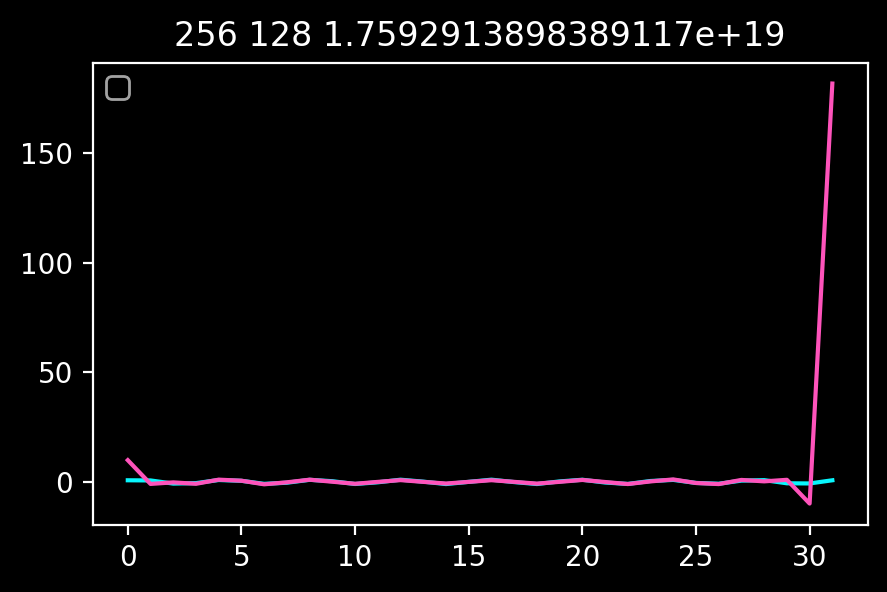

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


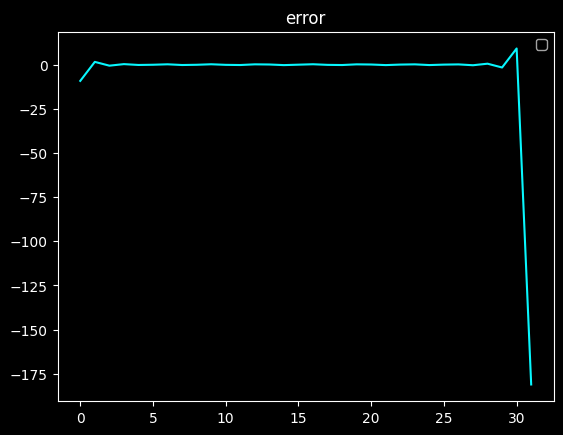

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, k):
    return np.sin(x * 2 * np.pi * k)

N = 32
precisions = [200]
k = 4

fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
for cutoff in [1e-8]:
    for n_ext in [256]:
        for n_mode in [128]:
            Ms = []
            for precision in precisions:
                M_int, x, x_int = f2ext(n_phys = N, n_ext = n_ext, n_mode=n_mode, precision = precision, cutoff=cutoff)
                Ms.append(M_int)

            # Set values for N and the range of k to test
            k_values = 2 * np.logspace(-2, 1, 20)  # Example range of k from 1 to 100 in logarithmic scale

            # Generate grids
            x      = np.linspace(-1, 1, N)
            dx     = x[1] - x[0]
            x_eval = -1 + np.arange(N) * dx + dx/2

            for precision, M in zip(precisions, Ms):
                # Initialize L1 error list
                l1_errors = []
                M_numpy = np.array(M.tolist()).astype(complex)

                # Compute function values on original and evaluation grids
                f_x      = f(x, k)
                f_x_eval = f(x_eval, k)

                # Interpolate using M (placeholder function)
                f_interpolated = M_numpy @ f_x

                plt.title(f"{n_ext} {n_mode} {np.linalg.cond(M_numpy)}")
                plt.plot(f_x_eval)
                plt.plot(f_interpolated)
                plt.legend()
                plt.show()
                plt.plot(f_x_eval - f_interpolated)
                plt.legend()
                plt.title(f'error')
                plt.show()

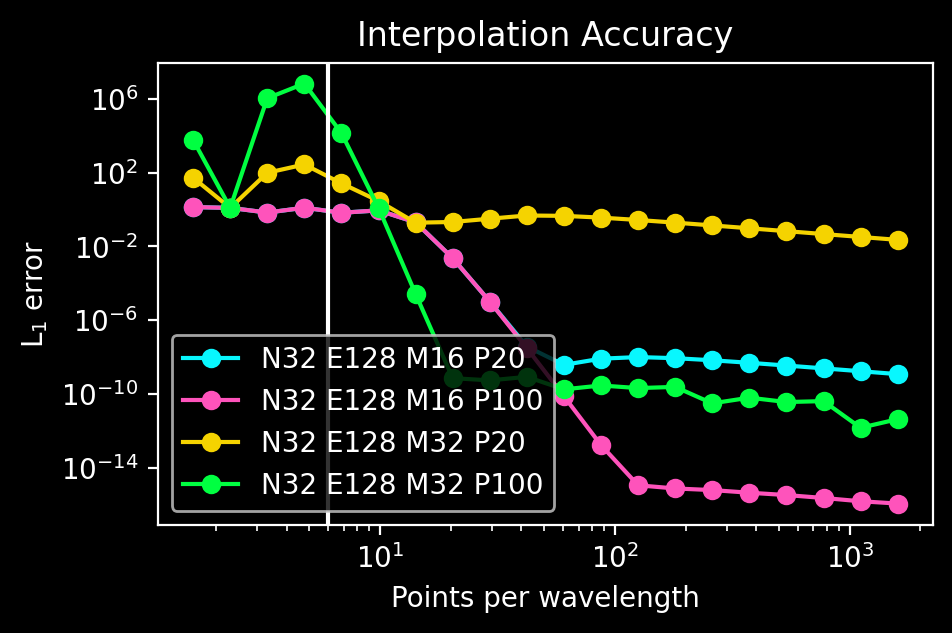

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def f(x, k):
    return np.sin(x * 2 * np.pi * k)

N = 32
precisions = [20, 100]


fig, axs = plt.subplots(figsize=(5 , 3), dpi=200)
for cutoff in [0]:
    for n_ext in [128]:
        for n_mode in [16, 32]:
            Ms = []
            for precision in precisions:
                M_int, x, x_int = f2ext(n_phys = N, n_ext = n_ext, n_mode=n_mode, precision = precision, cutoff=cutoff)
                Ms.append(M_int)

            # Set values for N and the range of k to test
            k_values = 2 * np.logspace(-2, 1, 20)  # Example range of k from 1 to 100 in logarithmic scale

            # Generate grids
            x      = np.linspace(-1, 1, N)
            dx     = x[1] - x[0]
            x_eval = -1 + np.arange(N) * dx + dx/2

            for precision, M in zip(precisions, Ms):
                # Initialize L1 error list
                l1_errors = []
                M_numpy = np.array(M.tolist()).astype(complex)

                for k in k_values:
                    # Compute function values on original and evaluation grids
                    f_x      = f(x, k)
                    f_x_eval = f(x_eval, k)

                    # Interpolate using M (placeholder function)
                    f_interpolated = M_numpy @ f_x

                    # Compute L1 error
                    l1_error = np.mean(np.abs(f_interpolated[:N] - f_x_eval))
                    l1_errors.append(l1_error)

                # Plot results
                plt.loglog(N / k_values, l1_errors, 'o-', label=f"N{N} E{n_ext} M{n_mode} P{precision}")

plt.axvline(6)
plt.legend()
plt.xlabel('Points per wavelength')
plt.ylabel('L$_1$ error')
plt.title(f'Interpolation Accuracy')
plt.show()